In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

# Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, auc, fbeta_score, f1_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
#from scipy.stats import boxcox, yeojohnson

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

## Model saving
from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

# Evaluation Functions

In [2]:
def partial_auc_score(y_actual, y_scores, tpr_threshold=0.80):
    max_fpr = 1 - tpr_threshold

    # create numpy arrays
    y_actual = np.asarray(y_actual)
    y_scores = np.asarray(y_scores)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_actual, y_scores)

    # Find the index where fpr exceeds max_fpr
    stop_index = np.searchsorted(fpr, max_fpr, side='right')

    if stop_index < len(fpr):
        # Interpolate to find the TPR at max_fpr
        fpr_interp_points = [fpr[stop_index - 1], fpr[stop_index]]
        tpr_interp_points = [tpr[stop_index - 1], tpr[stop_index]]
        tpr = np.append(tpr[:stop_index], np.interp(max_fpr, fpr_interp_points, tpr_interp_points))
        fpr = np.append(fpr[:stop_index], max_fpr)
    else:
        tpr = np.append(tpr, 1.0)
        fpr = np.append(fpr, max_fpr)

    # Calculate partial AUC
    partial_auc_value = auc(fpr, tpr)

    return partial_auc_value
    
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             pauc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Training data with labels or targets
    X_test            Testing data with features
    y_test            Testing data with labels or targets                             
    training=True     True: print scores on the training set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
        
    if pauc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('pAUC on trainig set: ', round(partial_auc_score(y_train, y_pred_train_p), 4))
        if test:
            print('pAUC on test set: ', round(partial_auc_score(y_test, y_pred_test_p), 4))
        print("--------"*5)
        
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 pauc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parameters "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary including hyperparameters
    X_train               #Training data with features
    y_train               #Training data with labels or targets
    X_test                #Testing data with features
    y_test                #Testing data with labels or targets
    cv=5                  #Number of cross-validation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the training set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Possible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the confusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             pauc=pauc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params

# Exploratory Data Analysis (EDA)

In [3]:
# Read the dataset
ROOT_DATASET_DIR = "./"
file_name = os.path.join(ROOT_DATASET_DIR,"train-metadata-eda.csv")
df_eda = pd.read_csv(file_name)

In [4]:
# Analyze de features
df_eda.head(5)

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,log_tbp_lv_deltaLBnorm,log_tbp_lv_minorAxisMM,log_tbp_lv_norm_border,log_tbp_lv_norm_color,log_tbp_lv_perimeterMM,log_tbp_lv_radial_color_std_max,log_tbp_lv_stdL,log_tbp_lv_stdLExt,log_tbp_lv_symm_2axis,sqr_tbp_lv_eccentricity
0,ISIC_0015670,0,60.0,0,lower extremity,3.04,0,20.244422,16.261975,26.922447,...,1.914611,0.933351,2.090797,0.000000,2.332824,0.000000,1.110605,1.291374,0.464033,0.812345
1,ISIC_0015845,0,60.0,0,head/neck,1.10,0,31.712570,25.364740,26.331000,...,1.789631,0.599890,1.136679,0.000000,1.471129,0.000000,0.616928,1.591853,0.251314,0.409453
2,ISIC_0015864,0,60.0,0,posterior torso,3.40,1,22.575830,17.128170,37.970460,...,1.986553,0.786139,1.757571,0.000000,2.291151,0.000000,1.009290,1.082069,0.308884,0.868898
3,ISIC_0015902,0,65.0,0,anterior torso,3.22,1,14.242329,12.164757,21.448144,...,2.001507,1.247414,1.090538,1.019463,2.352755,0.509639,0.814719,0.945357,0.190274,0.428316
4,ISIC_0024200,0,55.0,0,anterior torso,2.73,0,24.725520,20.057470,26.464900,...,2.019068,0.657476,1.538769,0.000000,2.010569,0.000000,1.126684,1.247179,0.272644,0.895763


In [5]:
df_eda.drop(columns=['isic_id'], inplace=True)
df_eda['anatom_site_general'] = pd.Categorical(df_eda['anatom_site_general'])
df_eda['tbp_lv_location'] = pd.Categorical(df_eda['tbp_lv_location'])
df_eda['tbp_lv_location_simple'] = pd.Categorical(df_eda['tbp_lv_location_simple'])
df_eda['sex'] = pd.Categorical(df_eda['sex'])
df_eda.dtypes

target                                int64
age_approx                          float64
sex                                category
anatom_site_general                category
clin_size_long_diam_mm              float64
tbp_tile_type                         int64
tbp_lv_A                            float64
tbp_lv_Aext                         float64
tbp_lv_B                            float64
tbp_lv_Bext                         float64
tbp_lv_C                            float64
tbp_lv_Cext                         float64
tbp_lv_H                            float64
tbp_lv_Hext                         float64
tbp_lv_L                            float64
tbp_lv_Lext                         float64
tbp_lv_areaMM2                      float64
tbp_lv_area_perim_ratio             float64
tbp_lv_color_std_mean               float64
tbp_lv_deltaA                       float64
tbp_lv_deltaB                       float64
tbp_lv_deltaL                       float64
tbp_lv_deltaLB                  

# Baseline: Logistic Regression

In [6]:
# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Modified feature names
log_features = ['log_' + col for col in features_to_be_logtr]
sqr_features = ['sqr_' + col for col in features_to_be_sqrtr]

# Train-Test Split

In [7]:
# Define predictors and target variable
X1 = df_eda.drop(['target']         # Drop target
                 + log_features     # Drop original features with log transformation
                 + sqr_features,    # Drop original features with sqr transformation
                 axis=1)
y = df_eda['target']
print(f"We have {X1.shape[0]} observations in our dataset and {X1.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 395303 observations in our dataset and 39 features
Our target vector has also 395303 values


In [8]:
# Split into train and test set 
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
numerical_features = X1.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X1.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'clin_size_long_diam_mm', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']
Categorical features: ['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']


In [10]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler())
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([    
    ('features', preprocessing_lr),    
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#            'LR__solver': ['liblinear', 'saga']
#            }
param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr1, _ = train_crossval_predict_score(pipe_lr,
                                            param_lr,
                                            X1_train,
                                            y_train,
                                            X1_test,
                                            y_test,
                                            cv=5,
                                            scoring='roc_auc',
                                            cross_val='full',
                                            training=True,
                                            test=True,
                                            accuracy=False,
                                            recall=False,
                                            precision=False,
                                            fbeta=[False, 1.0],
                                            roc_auc=False,
                                            pauc=True,
                                            matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1336
pAUC on test set:  0.1207
----------------------------------------


# Skewness Correction: Log and Square

In [12]:
# Define predictors and target variable
X2 = df_eda.drop(['target']                 # Drop target
                 + features_to_be_logtr     # Drop original features without log transformation
                 + features_to_be_sqrtr,    # Drop original features without sqr transformation
                 axis=1)
# Train-Test split
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Determine numerical and categorical features
numerical_features = X2.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X2.select_dtypes(include=['category']).columns.tolist()
print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Numerical features: ['age_approx', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_nevi_confidence', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'log_clin_size_long_diam_mm', 'log_tbp_lv_areaMM2', 'log_tbp_lv_area_perim_ratio', 'log_tbp_lv_color_std_mean', 'log_tbp_lv_deltaLB', 'log_tbp_lv_deltaLBnorm', 'log_tbp_lv_minorAxisMM', 'log_tbp_lv_norm_border', 'log_tbp_lv_norm_color', 'log_tbp_lv_perimeterMM', 'log_tbp_lv_radial_color_std_max', 'log_tbp_lv_stdL', 'log_tbp_lv_stdLExt', 'log_tbp_lv_symm_2axis', 'sqr_tbp_lv_eccentricity']
Categorical features: ['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']


In [14]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler())
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([    
    ('features', preprocessing_lr),    
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#            'LR__solver': ['liblinear', 'saga']
#            }
param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr2, _ = train_crossval_predict_score(pipe_lr,
                                            param_lr,
                                            X2_train,
                                            y_train,
                                            X2_test,
                                            y_test,
                                            cv=5,
                                            scoring='roc_auc',
                                            cross_val='full',
                                            training=True,
                                            test=True,
                                            accuracy=False,
                                            recall=False,
                                            precision=False,
                                            fbeta=[False, 1.0],
                                            roc_auc=False,
                                            pauc=True,
                                            matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1491
pAUC on test set:  0.1345
----------------------------------------


# Dimensionality Reduction

In [16]:
numerical_features = X2.select_dtypes(include=['float64','int64']).columns.tolist()
categorical_features = X2.select_dtypes(include=['category']).columns.tolist()

In [17]:
# Use SelectKBest for numerical features
Kbest_numerical = SelectKBest(score_func=f_classif, k='all')
Kbest_numerical.fit(X2_train[numerical_features], y_train)

# Extract feature scores and p-values
scores = Kbest_numerical.scores_
pvalues = Kbest_numerical.pvalues_

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
kbest_num = sorted_features.shape[0]
print(f"Number of relevant numerical features: {kbest_num}\n")
print(sorted_features.set_index('Feature'))

Number of relevant numerical features: 30

                                      Score        P-Value
Feature                                                   
tbp_lv_H                         596.935096  1.030472e-131
tbp_lv_deltaB                    385.672387   8.152815e-86
tbp_lv_Hext                      332.404923   3.141478e-74
tbp_lv_B                         226.011817   4.600609e-51
log_tbp_lv_areaMM2               205.051666   1.706404e-46
log_tbp_lv_minorAxisMM           198.599426   4.356578e-45
log_tbp_lv_stdLExt               191.037392   1.943343e-43
log_tbp_lv_perimeterMM           158.650954   2.275902e-36
tbp_lv_Aext                      157.930965   3.268842e-36
log_clin_size_long_diam_mm       150.672038   1.258824e-34
tbp_lv_A                          99.723954   1.765997e-23
log_tbp_lv_radial_color_std_max   92.476610   6.859721e-22
tbp_tile_type                     76.716276   1.983142e-18
log_tbp_lv_color_std_mean         74.647369   5.653162e-18
tbp_lv_nevi_c

In [18]:
# Use SelectKBest for categorical features
# Build a pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('onehot', preprocessor),
    ('kbest', SelectKBest(score_func=chi2, k='all'))
])

cat_transformed = pipeline.fit_transform(X2_train, y_train)
Kbest_categorical = pipeline.named_steps['kbest']

# Extract feature scores and p-values
scores = Kbest_categorical.scores_
pvalues = Kbest_categorical.pvalues_

# Extract feature names after one-hot encoding
one_hot_feature_names = pipeline.named_steps['onehot'].transformers_[0][1].get_feature_names_out(categorical_features)

# Create a DataFrame to hold feature names, scores, and p-values
feature_scores = pd.DataFrame({
    'Feature': one_hot_feature_names,
    'Score': scores,
    'P-Value': pvalues
})

# Sort features by their scores
best_feature_scores = feature_scores[feature_scores['P-Value'] < 0.05]
sorted_features = best_feature_scores.sort_values(by='Score', ascending=False)

# Display the sorted features
kbest_cat = sorted_features.shape[0]
print(f"Number of relevant categorical features: {kbest_cat}\n")
print(sorted_features.set_index('Feature'))

Number of relevant categorical features: 8

                                              Score       P-Value
Feature                                                          
anatom_site_general_head/neck            309.765912  2.455948e-69
tbp_lv_location_Left Leg                  12.235153  4.689749e-04
tbp_lv_location_Right Leg - Upper         11.134642  8.473028e-04
tbp_lv_location_simple_Right Leg           6.138519  1.322681e-02
tbp_lv_location_Torso Back Middle Third    5.859480  1.549337e-02
tbp_lv_location_simple_Right Arm           5.478735  1.924919e-02
tbp_lv_location_Torso Front Bottom Half    4.512864  3.364087e-02
anatom_site_general_lower extremity        4.258931  3.904449e-02


According to this analysis, some non-essential features can be removed. A total of 30 numerical features and 8 categorical features have been identified as the most relevant in explaining the relationship with the output variable.

In [19]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num))
])

pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat))
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([    
    ('features', preprocessing_lr),  
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.01, 0.1, 1, 10, 100],
#            'LR__solver': ['liblinear', 'saga']
#            }

param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr3, _ = train_crossval_predict_score(pipe_lr,
                                            param_lr,
                                            X2_train,
                                            y_train,
                                            X2_test,
                                            y_test,
                                            cv=5,
                                            scoring='roc_auc',
                                            cross_val='full',
                                            training=True,
                                            test=True,
                                            accuracy=False,
                                            recall=False,
                                            precision=False,
                                            fbeta=[False, 1.0],
                                            roc_auc=False,
                                            pauc=True,
                                            matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1487
pAUC on test set:  0.1367
----------------------------------------


# PCA

In [21]:
# Pipeline
pipe_num = Pipeline([
    ('scaler', RobustScaler()),     
    ('kbest', SelectKBest(score_func=f_classif, k=kbest_num)),        
    ('pca', PCA(n_components=kbest_num)),
   
])
# n_components
pipe_cat = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),        
    ('kbest', SelectKBest(score_func=chi2, k=kbest_cat)),
    ('pca', PCA(n_components=kbest_cat)),
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([    
    ('features', preprocessing_lr),  
    ('LR', LogisticRegression(max_iter=1000))
])

#param_lr = {'LR__penalty':('l1','l2'),
#            'LR__C': [0.01, 0.1, 1, 10, 100],
#            'LR__solver': ['liblinear', 'saga']
#            }

param_lr = {'LR__penalty': ['l1'],
            'LR__C': [10],
            'LR__solver': ['liblinear']
            }

# Train, cross-validate, predict, and score
model_lr4, _ = train_crossval_predict_score(pipe_lr,
                                            param_lr,
                                            X2_train,
                                            y_train,
                                            X2_test,
                                            y_test,
                                            cv=5,
                                            scoring='roc_auc',
                                            cross_val='full',
                                            training=True,
                                            test=True,
                                            accuracy=False,
                                            recall=False,
                                            precision=False,
                                            fbeta=[False, 1.0],
                                            roc_auc=False,
                                            pauc=True,
                                            matrix=False)
# Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}

Best params: {'LR__C': 10, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
pAUC on trainig set:  0.1488
pAUC on test set:  0.1367
----------------------------------------


# Evaluate Models

In [23]:
#model_lrb = load('model_lr_base.pkl')
#model_lr1 = load('model_lr_log.pkl')
#model_lr1r = load('model_lr_log_red.pkl')
#model_lr1rp = load('model_lr_log_red_pca.pkl')
#model_lr2 = load('model_lr_bxx.pkl')

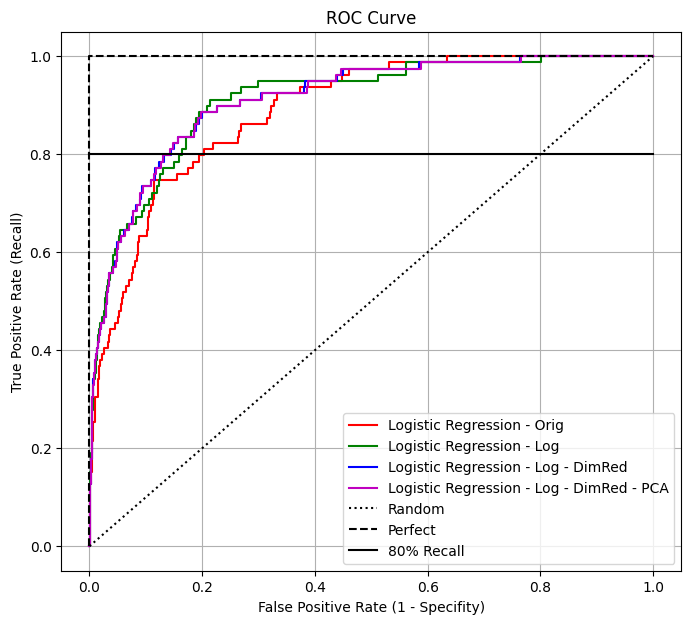

In [24]:
fpr_lr1, tpr_lr1, thr_lr1 = roc_curve(y_test, model_lr1.predict_proba(X1_test)[:,1])
fpr_lr2, tpr_lr2, thr_lr2 = roc_curve(y_test, model_lr2.predict_proba(X2_test)[:,1])
fpr_lr3, tpr_lr3, thr_lr3 = roc_curve(y_test, model_lr3.predict_proba(X2_test)[:,1])
fpr_lr4, tpr_lr4, thr_lr4 = roc_curve(y_test, model_lr4.predict_proba(X2_test)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr1, tpr_lr1, 'r-', label = 'Logistic Regression - Orig')
plt.plot(fpr_lr2, tpr_lr2, 'g-', label = 'Logistic Regression - Log')
plt.plot(fpr_lr3, tpr_lr3, 'b-', label = 'Logistic Regression - Log - DimRed')
plt.plot(fpr_lr4, tpr_lr4, 'm-', label = 'Logistic Regression - Log - DimRed - PCA')
plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.plot([0,1],[0.8,0.8],'k-',label='80% Recall')
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.show()

Based on the results, we can select the **LR-Log-DimRed model** as a baseline.

This model will be saved as **model_lr_baseline.pkl**.

In [25]:
 # Save the best model
dump(model_lr3, 'model_lr_baseline.pkl')

['model_lr_baseline.pkl']

# On the Test Set

In [26]:
# Read the test dataset
ROOT_DATASET_DIR = "./"
file_name_t = os.path.join(ROOT_DATASET_DIR,"test-metadata-eda.csv")
df_eda_orig = pd.read_csv(file_name_t)
df_eda_t = pd.read_csv(file_name_t)
df_eda_t.drop(columns=['isic_id'], inplace=True)
df_eda_t['anatom_site_general'] = pd.Categorical(df_eda_t['anatom_site_general'])
df_eda_t['tbp_lv_location'] = pd.Categorical(df_eda_t['tbp_lv_location'])
df_eda_t['tbp_lv_location_simple'] = pd.Categorical(df_eda_t['tbp_lv_location_simple'])

# Original feature names
features_to_be_logtr = ['clin_size_long_diam_mm',
                        'tbp_lv_areaMM2',
                        'tbp_lv_area_perim_ratio',
                        'tbp_lv_color_std_mean',
                        'tbp_lv_deltaLB',
                        'tbp_lv_deltaLBnorm',
                        'tbp_lv_minorAxisMM',
                        'tbp_lv_norm_border',
                        'tbp_lv_norm_color',
                        'tbp_lv_perimeterMM',
                        'tbp_lv_radial_color_std_max',
                        'tbp_lv_stdL',
                        'tbp_lv_stdLExt',
                        'tbp_lv_symm_2axis']
features_to_be_sqrtr = ['tbp_lv_eccentricity']

# Train-Test split
X_test_ = df_eda_t.drop(features_to_be_logtr + features_to_be_sqrtr, axis=1)

# Load model
model_lr_baseline = load('model_lr_baseline.pkl')
y_pred_ = model_lr_baseline.predict_proba(X_test_)[:,1]

# Create a DataFrame with 'isic_id' and 'target'
df_submission = pd.DataFrame({
    'isic_id': df_eda_orig['isic_id'],
    'target': y_pred_
})

# Save the DataFrame
df_submission.to_csv('submission_baseline.csv', index=False)